### Load data

In [1]:
from keras.datasets import mnist
import numpy as np
import sklearn
print(sklearn.__version__)

Using TensorFlow backend.


0.20.3


In [2]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Shuffle training data
Shuffling training data ensures that the all cross-validation folds are similar

In [3]:
np.random.seed(42)

shuffle_index = np.random.permutation(xtrain.shape[0])

xtrain = xtrain[shuffle_index]
ytrain = ytrain[shuffle_index]

### Display an example

(28, 28)
9


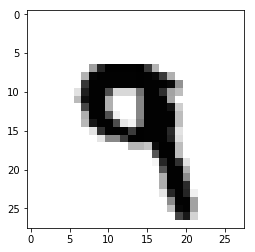

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = xtrain[3600]
print(some_digit.shape)
# plt.imshow(some_digit)
# plt.imshow(some_digit, cmap=plt.cm.gray)
# plt.imshow(some_digit, cmap=plt.cm.binary)
plt.imshow(some_digit, cmap=plt.cm.binary, interpolation="nearest")
print(ytrain[3600])

### Training binary classification

In [5]:
# if ytrain=5 then true, else false -> binary classification
ytrain_5 = (ytrain == 5)
# reshape xtrain into 2d array because typical ML algorithms work only for 2d array (sample * features)
img_size = xtrain.shape[1]*xtrain.shape[2]
xtrain_reshaped = xtrain.reshape(xtrain.shape[0], img_size)
print(xtrain_reshaped.shape)

(60000, 784)


### Classifying using SGDClassifier

In [6]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42, max_iter=300, tol=1.e-2)

sgd.fit(xtrain_reshaped, ytrain_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=300,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.01,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
# prediction
ytrain_pred = sgd.predict(xtrain_reshaped)
y3600_pred = sgd.predict(some_digit.reshape(1, img_size))
# this mean not 5
print(y3600_pred)

[False]


### Evaluate

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

In [9]:
# macro weighs each class equally whereas micro weights each sample equally
# we want to bias the metrics toward small class (a digit is 5), so we use macro
print(sorted(sklearn.metrics.SCORERS.keys()))
scoring = ['precision_macro', 'recall_macro', "accuracy", "f1_macro"]
scores = cross_validate(SGDClassifier(random_state=42, tol=1.e-2, max_iter=300), 
                        xtrain_reshaped, ytrain_5, scoring=scoring, cv=3, return_train_score=True)

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']


In [10]:
print(scores.keys())
print(scores["train_accuracy"])
print(scores["test_accuracy"])
print(scores["train_precision_macro"])
print(scores["test_precision_macro"])
print(scores["train_recall_macro"])
print(scores["test_recall_macro"])
print(scores["train_f1_macro"])
print(scores["test_f1_macro"])

dict_keys(['fit_time', 'score_time', 'test_precision_macro', 'train_precision_macro', 'test_recall_macro', 'train_recall_macro', 'test_accuracy', 'train_accuracy', 'test_f1_macro', 'train_f1_macro'])
[0.9185 0.9688 0.9182]
[0.9155  0.96355 0.9135 ]
[0.75986044 0.91561016 0.75910132]
[0.75485057 0.89234148 0.75033162]
[0.92031194 0.88951817 0.91703181]
[0.9179153  0.88351722 0.90385661]
[0.8125561  0.90203073 0.81124562]
[0.80745094 0.88786534 0.80071177]


### Confusion matrix
Since our data are imbalanced, the digit 5 is only about 10% of the whole data set, so a dummy classifier which always predicts negative would have the accuracy of 90%. For this case it is a good pratice to look at the confunsion matrix

In [11]:
from sklearn.model_selection import cross_val_predict

ytrain_pred = cross_val_predict(SGDClassifier(random_state=42, max_iter=300, tol=1.e-2),
                               xtrain_reshaped, ytrain_5, cv=3)

In [12]:
tn, fp, fn, tp = confusion_matrix(ytrain_5, ytrain_pred).ravel()
print(confusion_matrix(ytrain_5, ytrain_pred))

[[51155  3424]
 [  725  4696]]


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(ytrain_5, ytrain_pred))
print(recall_score(ytrain_5, ytrain_pred))
print(f1_score(ytrain_5, ytrain_pred))

0.5783251231527093
0.8662608374838591
0.6935972232479137


### Precision-recall curve with cross validation

In [15]:
ytrain_scores = cross_val_predict(SGDClassifier(random_state=42, max_iter=300, tol=1.e-2),
                               xtrain_reshaped, ytrain_5, cv=3, method="decision_function")

In [16]:
# score for a single sample
y3600_score = sgd.decision_function(some_digit.reshape(1, img_size))
print(y3600_score)

[-5768.07123217]


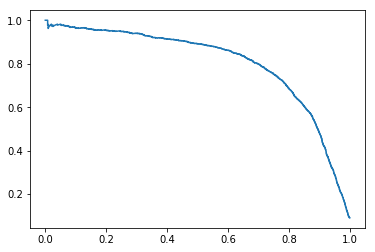

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(ytrain_5, ytrain_scores)

plt.plot(recalls, precisions)

59960
59961 59961


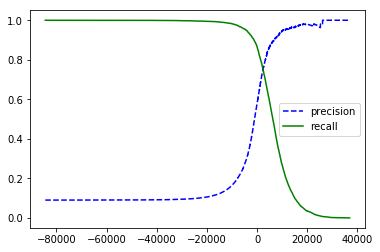

In [18]:
print(len(thresholds))
print(len(recalls), len(precisions))
plt.plot(thresholds, precisions[:-1], "b--", label="precision")
plt.plot(thresholds, recalls[:-1], "g-", label="recall")
plt.legend()

- You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop—for example, at around 60% recall. But of course the choice depends on your project.

- So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to use a threshold of about 70,000. To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can just run this code:

In [20]:
y_train_pred_90 = (ytrain_scores > 20000)
print(precision_score(ytrain_5, y_train_pred_90))
print(recall_score(ytrain_5, y_train_pred_90))

0.9795918367346939
0.03541781959048146


__Note__: A high-precision classifier is not very useful if its recall is too low! If someone says “let’s reach 99% precision,” you should ask, “at what recall?”

### The ROC-curve

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(ytrain_5, ytrain_scores)

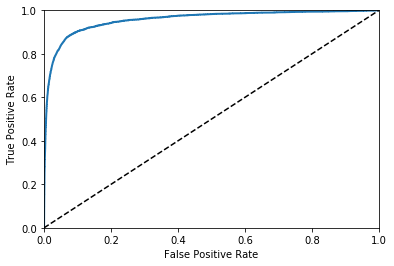

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [23]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(ytrain_5, ytrain_scores))

0.9572173692408094


As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
ytrain_forest_scores = cross_val_predict(RandomForestClassifier(random_state=42),
                                        xtrain_reshaped, ytrain_5, cv=3,
                                        method="predict_proba")

/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Compare recall-precision curves

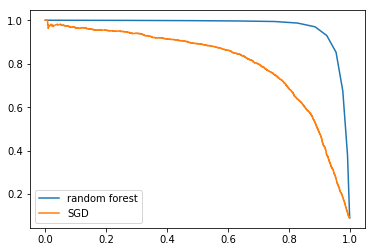

In [26]:
# score for positive class
ytrain_rf_scores = ytrain_forest_scores[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(ytrain_5, ytrain_rf_scores)

fig, ax = plt.subplots()
ax.plot(recall_rf, precision_rf, label="random forest")
ax.plot(recalls, precisions, label="SGD")
ax.legend()

### Compare ROC curve

In [27]:
fpr_rf, tpr_rf, threshold_roc_rf = roc_curve(ytrain_5, ytrain_rf_scores)

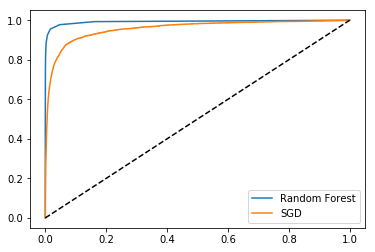

In [28]:
fig, ax = plt.subplots()
ax.plot(fpr_rf, tpr_rf, label="Random Forest")
ax.plot(fpr, tpr, label="SGD")
ax.plot([0,1], [0,1], "k--")
ax.legend()

## Multiclass classification

- Some classifiers can directly work with multiclass classification task, for example RandomForest, SGD, or naive BAyes. Some cannot directly, for example SVM or linear classifier. The later ones can also be used for multiclass classification by using one of the 2 following strategy: one vs. rest or one vs. one.

- For digits we have 10 classes (0 to 9). One versus rest approach requires training 10 classifiers (0-detector, 1-detector, ...). One versus one approach requires to train N(N-1)/2 = 45 classifiers. However, the training data for each classifier in one vs. one approach is smaller.

- SVM is not good for scaling of the training data. Therefore for SVM it is better to train 45 classifiers with smaller training data than 10 classifiers with bigger training data. For others, it is better to use one vs. rest approach


### Using SGDClassifier, predict one sample

In [29]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(xtrain_reshaped, ytrain)
y3600_pred = sgd_clf.predict(xtrain[3600].reshape(1, img_size))
print(y3600_pred)

/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


[9]


What the algorithm actually did is training 10 different classifiers. When an input image is given, it use all 10 classifiers to predict and then choose the one with the highest score from the results

In [30]:
y3600_score = sgd_clf.decision_function(xtrain[3600].reshape(1, img_size))
y3600_score

array([[-1081183.65699976,  -389593.2854482 ,  -580525.16975929,
         -352328.54930284,   -47731.72376566,  -133463.12458932,
         -656800.24311324,  -124523.55611606,  -341984.01170307,
           -3363.20923264]])

In [31]:
print(np.argmax(y3600_score))

9


In [32]:
classes = sgd_clf.classes_
print(classes)
print(classes[np.argmax(y3600_score)])

[0 1 2 3 4 5 6 7 8 9]
9


### Using RandomForestClassifier, predict one sample

In [33]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=30)
rf_clf.fit(xtrain_reshaped, ytrain)
y3600_rf_pred = rf_clf.predict(xtrain[3600].reshape(1, img_size))
print(y3600_rf_pred)

[9]


In [34]:
y3600_rf_scores = rf_clf.predict_proba(xtrain[3600].reshape(1, img_size))
print(y3600_rf_scores)

print(rf_clf.classes_)
print(rf_clf.classes_[np.argmax(y3600_rf_scores)])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[0 1 2 3 4 5 6 7 8 9]
9


### Cross validation/ Evaluation with SGDClassifier

In [35]:
sgd_multi_scores = cross_validate(SGDClassifier(random_state=42), 
                                  xtrain_reshaped, ytrain, cv=3, scoring="accuracy")

/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassi

In [36]:
print(sgd_multi_scores["test_score"])

[0.81908618 0.86379319 0.84492674]


Using the same classifier with rescaled data

In [37]:
from sklearn.preprocessing import StandardScaler

xtrain_rescaled = StandardScaler().fit_transform(xtrain_reshaped)
sgd_multi_scaled_scores = cross_validate(SGDClassifier(random_state=42), 
                                         xtrain_rescaled, ytrain, cv=3, scoring="accuracy")

/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureW

In [38]:
print(sgd_multi_scaled_scores["test_score"])

[0.91131774 0.90884544 0.90883633]


### Cross validation/Evaluation with RandomForestClassifier

In [39]:
# evaluate random forest
rf_multi_scores = cross_validate(RandomForestClassifier(random_state=42, n_estimators=10),
                                 xtrain_reshaped, ytrain, cv=3, scoring="accuracy")

In [40]:
print(rf_multi_scores.keys())
print(rf_multi_scores["test_score"])

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])
[0.94031194 0.94144707 0.94059109]


In [41]:
# rescale data before training doesn't help in case of RandomForest
rf_multi_scaled_scores = cross_validate(RandomForestClassifier(random_state=42, n_estimators=10),
                                        xtrain_rescaled, ytrain, cv=3, scoring="accuracy")

In [42]:
print(rf_multi_scaled_scores["test_score"])

[0.94016197 0.94129706 0.94074111]


__Scaling is not necessary for RandomForest!!!__

### Force sklearn to use one vs one or one vs. rest

In sklearn by default, if we use SVM for multiclass classification, then it uses one vs. one approach. If we use other classification (such as SDG..) then it uses one vs. rest approach. However, we can also force the classifier to use a certain approach.

In [43]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=200, tol=1e-2))
ovo_clf.fit(xtrain_reshaped, ytrain)
print(len(ovo_clf.estimators_))

45


In [44]:
ovo_clf.predict(xtrain[3600].reshape(1, img_size))

array([9], dtype=uint8)

__Note__: RandomForest doesn't need to run OvO or OvA because it can directly classify instances into multiple classes

### Error analysis

In [45]:
ypred_rf_multi = cross_val_predict(RandomForestClassifier(random_state=42, n_estimators=10),
                                  xtrain_rescaled, ytrain, cv=3)
conf_mx = confusion_matrix(ytrain, ypred_rf_multi)

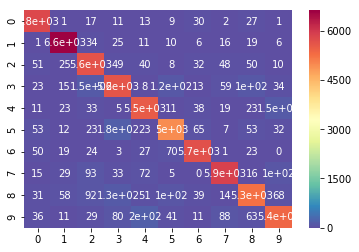

In [46]:
import seaborn as sns
sns.heatmap(conf_mx, annot=True, cmap=plt.cm.Spectral_r)

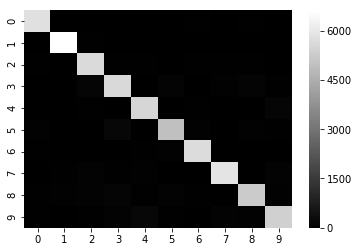

In [47]:
sns.heatmap(conf_mx, annot=False, cmap=plt.cm.gray)

In [48]:
#devide matrix by sum of rows
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums.shape)
rel_conf_mx = conf_mx/row_sums

(10, 1)


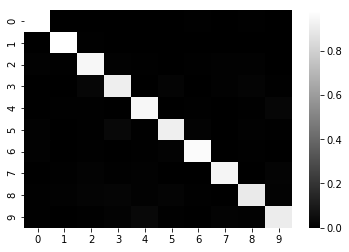

In [49]:
sns.heatmap(rel_conf_mx, annot=False, cmap=plt.cm.gray)

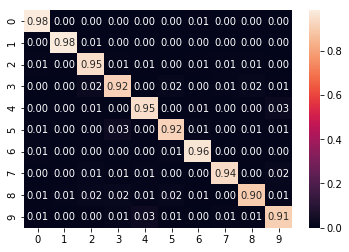

In [50]:
sns.heatmap(rel_conf_mx, annot=True, fmt=".2f")

If we one to focus only on the error, we can fill the diagonal with 0 first, and then plot

In [51]:
np.fill_diagonal(rel_conf_mx, 0)

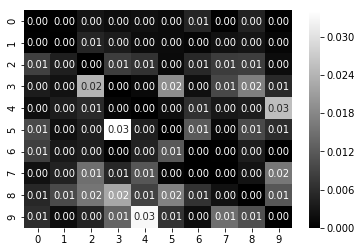

In [52]:
sns.heatmap(rel_conf_mx, annot=True, fmt=".2f", cmap=plt.cm.gray)

## Multilabel Classification

- Example: recognize several people on the same picture.
- Of course it should attach one label per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”).
- Such a classification system that ___outputs multiple binary labels__ is called a multilabel classification system.

#### Create multi labels

In [53]:
# label indicate if a digit is a large number
ytrain_large = (ytrain >=7)
# labe indicate if a digit is an odd number
ytrain_odd = (ytrain%2==1)
# multilabel (np.c_ is similar to column stack)
multi_label = np.c_[ytrain_large, ytrain_odd]
print(ytrain_large.shape)
print(ytrain_odd.shape)
print(multi_label.shape)

(60000,)
(60000,)
(60000, 2)


#### Train the model

In [54]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(xtrain_reshaped, multi_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

#### Predict one example

In [55]:
y3600_pred_multi = knn_clf.predict(xtrain[3600].reshape(1, img_size))
y3600_pred_multi # should return True, True because 9 is a large number and also an odd number

array([[ True,  True]])

#### Evaluation for multi label classification

One approach to evaluate multi label classification is use one of the metrics, for example, f1-score for each label, and then average them

__Note__ KNeighborsClassifier is __extremely slow__

In [56]:
from sklearn.metrics import f1_score

ytrain_pred_knn = cross_val_predict(KNeighborsClassifier(), xtrain_reshaped, multi_label, cv=3)

NameError: name 'ytrain_multi' is not defined

In [57]:
f1_avg = f1_score(multi_label, ytrain_pred_knn, average="macro")

print(f1_avg)

0.9768224011622285


If we want to weight different labels. For example, if Alice appears in the pictures much more often that Bob and Charlie, one of the simple way is use `average="weighted"`

In [58]:
f1_avg_w = f1_score(multi_label, ytrain_pred_knn, average="weighted")

print(f1_avg_w)

0.9781992561750247


## Multioutput Classification

- In the previous example, we looked at the case where we have more than one label, but each label has only 2 possible values (binary classification of each label). Now, if each label can have multiple values, the task is called multioutput classification

- For example, let’s build a system that removes noise from images: Input: a noisy digit image, output: clean digit image

- output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255)

### Create noisy MNIST from original data

In [61]:
xtest_reshaped = xtest.reshape(len(xtest), img_size)

# create noise
noise_train = np.random.randint(low=0, high=100, size=(len(xtrain_reshaped), img_size))
noise_test = np.random.randint(low=0, high=100, size=(len(xtest_reshaped), img_size))

# add noise to create training data 
xtrain_mod = xtrain_reshaped + noise_train
xtest_mod = xtest_reshaped + noise_test

# the original data are used as target
ytrain_mod = xtrain_reshaped
ytest_mod = xtest_reshaped

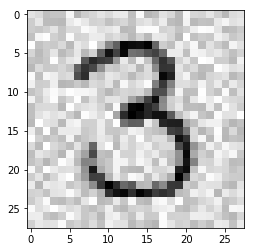

In [64]:
# let check how the noisy data compare to the original one
idx = 2500
plt.imshow(xtrain_mod[idx].reshape(28, 28), cmap=plt.cm.binary)

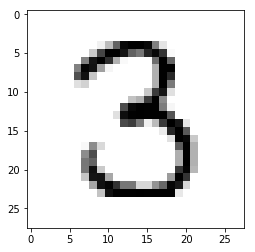

In [65]:
plt.imshow(ytrain_mod[idx].reshape(28, 28), cmap=plt.cm.binary)

Let’s train the classifier to clean the image

In [68]:
knn_clean = KNeighborsClassifier()
knn_clean.fit(xtrain_mod, ytrain_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

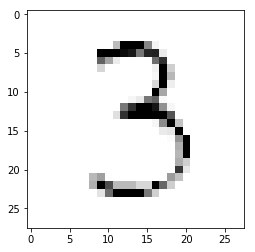

In [71]:
clean_digit = knn_clean.predict([xtrain_mod[idx]])
plt.imshow(clean_digit.reshape(28, 28), cmap=plt.cm.binary)